## Self-Taught Learning

In [1]:
#install packages 
#install.packages('gridExtra')
#install.packages('h2o')

options(warn=-1)
library(ggplot2) #For plotting
library(repr) #For reshape the file
library(reshape2) #For reshape the file

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


The code and the implementation of the model is derieved from acitvity 5.2 and codebase2C as the following:

I. Load Task2C_labeled.csv, Task2C_unlabeled.csv and Task2C_test.csv data sets and required libraries (e.g., H2O). Note
that we are going to use Task2C_labeled.csv and Task2C_unlabeled.csv for training the autoencoder. We are going to
use Task2C_labeled.csv for training the classifier. Finally, we evaluate the trained classifier on the test Task2C_test.csv.

In [2]:
#initialise H2o library for deep learning neural network
library(h2o)
h2o.init(nthreads = -1, port = 54321, max_mem_size = '6G', startH2O = TRUE)


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: 'h2o'

The following objects are masked from 'package:stats':

    cor, sd, var

The following objects are masked from 'package:base':

    %*%, %in%, &&, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc




H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\ASUS\AppData\Local\Temp\RtmpInyBGw\file41d0367557ee/h2o_ASUS_started_from_r.out
    C:\Users\ASUS\AppData\Local\Temp\RtmpInyBGw\file41d0ae19aa/h2o_ASUS_started_from_r.err


Starting H2O JVM and connecting:  Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 529 milliseconds 
    H2O cluster timezone:       Asia/Bangkok 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.36.0.4 
    H2O cluster version age:    543 years, 1 month and 12 days !!! 
    H2O cluster name:           H2O_started_from_R_ASUS_hdx932 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   6.00 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA

In [3]:
# Students: Use the "absolute" path to the datasets on your machine (important)
labeled.frame <- h2o.importFile(path ='./Task2C_labeled.csv' ,sep=',') 
unlabeled.frame <- h2o.importFile(path = './Task2C_unlabeled.csv' ,sep=',') 
test.frame <- h2o.importFile(path = './Task2C_test.csv' ,sep=',') 

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


II. Train an autoencoder (similar to Activity 5.2) with only one hidden layer and change the number of its neurons to: 20, 40, 60, 80, …, 440 (i.e. from 20 to 440 with a step size of 20).

In [4]:
#Separate label and unlabel for making a train and test frame
labeled.frame[,1] <- as.factor(labeled.frame$label)
train.frame <- h2o.rbind(labeled.frame[,-1], unlabeled.frame[,-1])
test.frame[,1] <- as.factor(test.frame$label)

# remove NA's
unlabeled.frame <- h2o.na_omit(unlabeled.frame)

In [5]:
#Calculation of an error rate of the model
error.rate <- function(Y1, T1){
  if (nrow(Y1)!=nrow(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/nrow(T1))
}

In [6]:
#Create empty dataframe for storing the error rate
reconstruction.train.error <- matrix(NA, nrow=22, ncol=1)
reconstruction.test.error <- matrix(NA, nrow=22, ncol=1)
layers <- list() #Store the autoencoder for the augmentation in the later process based on the number of neuron
i <- 1 #Incrementation starting point

# Build a neural network withautoencoder on train.frame similar to activity 5.2
for (k in seq(20, 440, 20)){
    NN.model <- h2o.deeplearning(    
        x = 1:ncol(train.frame), # select all pixels + extra features
        training_frame = train.frame, # specify the frame (imported file)
        hidden = k, # number of layers and their units
        activation = 'Tanh', # activation function 
        autoencoder = TRUE, # is it an autoencoder? Yes!
        l2 = 0.1)
    
    #Store the mean
    reconstruction.train.error[i,1] <- mean(h2o.anomaly(NN.model, train.frame)) 
    reconstruction.test.error[i,1] <- mean(h2o.anomaly(NN.model, test.frame))
    layers[[i]] <- h2o.deepfeatures(NN.model, labeled.frame, layer = 1) #Store the model by the number of layers
   
    i <- i+1
}    

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

III. For each model in Step II, calculate and record the reconstruction error which is simply the average (over all data points while the model is fixed) of Euclidian distances between the input and output of the autoencoder (you can simply use “h2o.anomaly()” function).Plot these values where the x-axis is the number of units in the middle layer and the y-axis is the reconstruction error. Then, save and attach the plot to your PDF report. Explain your findings based on the plot in
your PDF report.

In [7]:
# transform reconstruction error matrix to data frame 
reconstruction_train <- as.data.frame(reconstruction.train.error)
reconstruction_test <- as.data.frame(reconstruction.test.error)

reconstruction_train['type'] <- 'train'
reconstruction_test['type'] <- 'test'

reconstruction_train['K'] <- seq(20,440,20)
reconstruction_test['K'] <- seq(20,440,20)

reconstruction_error <- rbind(reconstruction_train,reconstruction_test)
names(reconstruction_error) <- c('error','type','K')

In [8]:
reconstruction_error

error,type,K
0.013626818,train,20
0.009757836,train,40
0.007571820,train,60
0.006410961,train,80
0.005562095,train,100
0.004989722,train,120
0.004683030,train,140
0.004256248,train,160
0.003939167,train,180
0.003770601,train,200


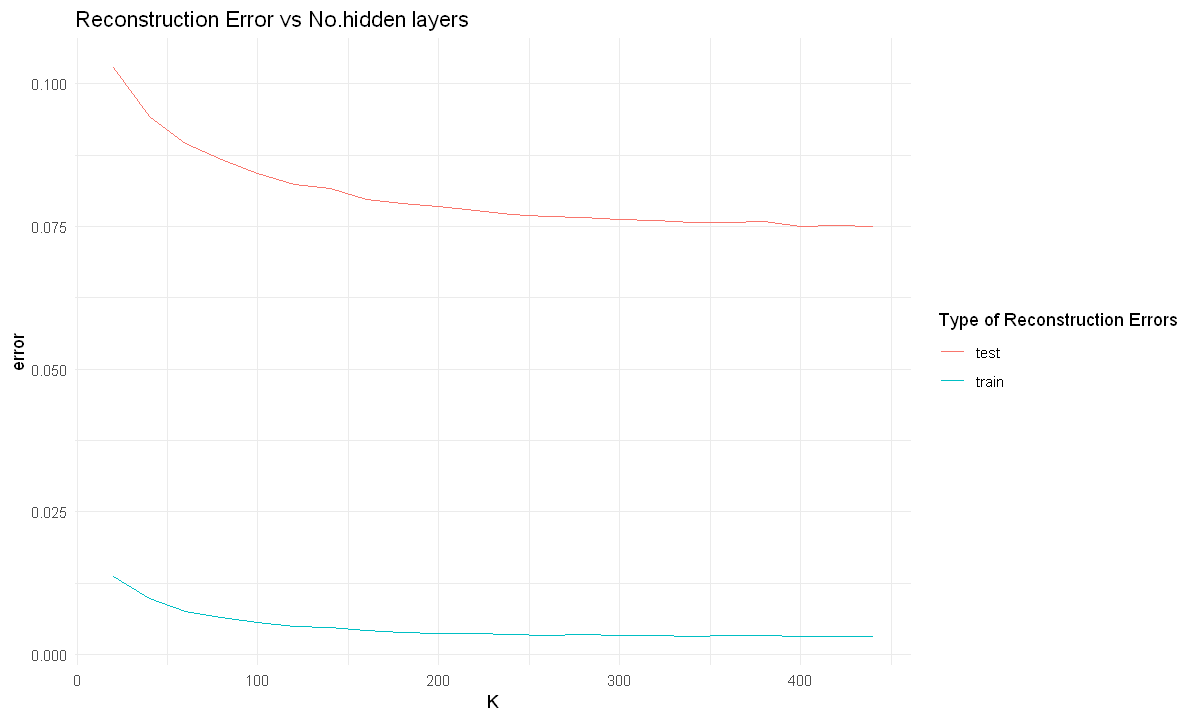

In [9]:
options(repr.plot.width = 10, repr.plot.height = 6) # Define plot size

#Plot of the reconstruction error and number of units in the middle layer
ggplot(data=reconstruction_error, aes(x=K, y=error, color=type)) +
    geom_line() + ggtitle('Reconstruction Error vs No.hidden layers') +
    scale_color_discrete(guide = guide_legend(title = 'Type of Reconstruction Errors')) +theme_minimal()

IV. Build the 3-layer NN from Activity 5.1 or “h2o.deeplearning” function (make sure you set “ autoencoder = FALSE”) to build a classification model using all the original attributes from the training set and change the number of its neurons to: 20, 40, 60, 80, .., 440 like Step II. For each model, calculate and record the test error.

In [10]:
#Create neural network from training dataframe
classification.test.error <- matrix(NA, nrow=22, ncol=1)
i <- 1

for (k in seq(20,440,20)){
    # build a neural network classifier based on the labeled training data
    NN.model <- h2o.deeplearning(    
        x = 2:ncol(labeled.frame), # select all pixels + extra features
        y = 1,
        training_frame = labeled.frame, # specify the frame (imported file)    
        hidden = c(k), # number of layers and their units  
        activation = 'Tanh', # activation function 
        autoencoder = FALSE, # is it an autoencoder? Yes!
        l2 = 0.1)
    
    test.predict <- h2o.predict(NN.model, test.frame)$predict
    classification.test.error[i,]<-error.rate(test.frame$label, test.predict)
    i <- i+1
}


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

V. Build augmented self-taught networks using the models learnt in Step II. For each model:

A. Add the output of the middle layer of an autoencoder as extra features to the original feature set.

B. Train a 3-layer NN using all features (original + extra) and varying the number of hidden neurons (like Step IV) as well. Then calculate and record the test error.

In [11]:
#Create neural network model with augmentation of autoencoder
classification.test.error.aug <- matrix(NA, nrow=22, ncol=1)
i <- 1

for (k in seq(20,440,20)){
    label_aug <- h2o.cbind(labeled.frame, layers[[i]])
    NN.model <- h2o.deeplearning(
        x = 2:ncol(label_aug), # select all pixels + extra features
        y = 1,
        training_frame = label_aug, # specify the frame (imported file)
        hidden = c(k), # number of layers and their units store model based on number of neuron (sequence of 20 to 440)
        activation = 'Tanh', # activation function 
        autoencoder = FALSE, # is it an autoencoder? No!
        l2 = 0.1)
   
    test_predict_aug <- h2o.predict(NN.model, test.frame)$predict
    classification.test.error.aug[i, ] <- error.rate(test.frame$label, test_predict_aug)
    i<-i+1
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

VI. Plot the error rates for the 3-layer neural networks from Step IV and the augmented self-taught networks from Step V, while the x-axis is the number of hidden neurons and y-axis is the classification error. Save and attach the plot to your PDF report. In your pdf, explain how the performance of the 3-layer neural networks and the augmented self-taught networks is different and why they are different or why they are not different, based on the plot.

In [12]:
#Create dataframe for plotting the error
class_test<-as.data.frame(classification.test.error)
class_test_aug <- as.data.frame(classification.test.error.aug)

class_test['augment'] <- 'Not Augment'
class_test_aug['augment'] <- 'Augment'

class_test['k'] <- seq(20,440,20)
class_test_aug['k'] <- seq(20,440,20)

class_error_df <- rbind(class_test,class_test_aug)
names(class_error_df) <- c('error','augment','k')

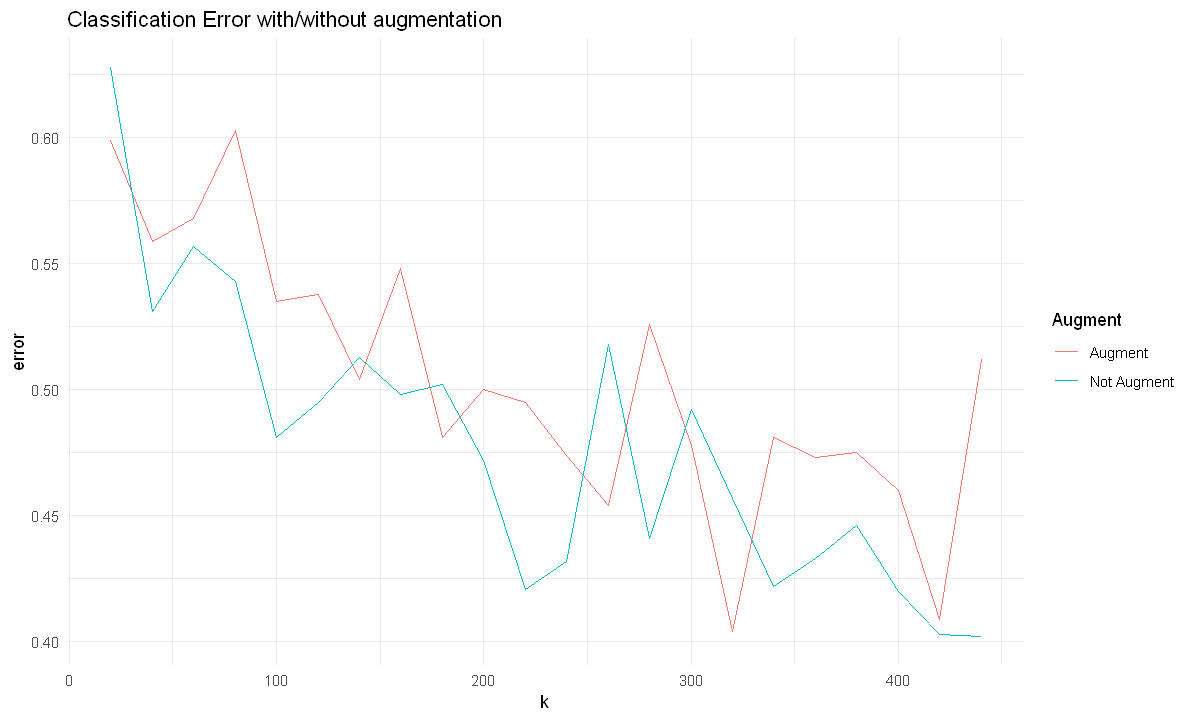

In [13]:
options(repr.plot.width = 10, repr.plot.height = 6) # Define plot size

#Plot of the reconstruction error and number of units in the middle layer
ggplot(data=class_error_df, aes(x=k, y=error, color=augment)) +
    geom_line() + ggtitle('Classification Error with/without augmentation') +
    scale_color_discrete(guide = guide_legend(title = 'Augment')) +theme_minimal()

## Reference

- Haffari, G. & Kazimipour, B. (2016, July). $\textit{codeBase2C.R}$. https://lms.monash.edu/pluginfile.php/14028238/mod_assign/intro/Dataset%20and%20Sample%20code_2022.zip
- Jupyter Notebooks:FIT5201 Machine Learning, (nd.). $\textit{Activity 5.1 Autoencoder}$. 
https://lms.monash.edu/mod/resource/view.php?id=10251992
- RDocumentation. (nd.)  $\textit{na.omit.H2OFrame: Remove Rows With NAs}$. https://www.rdocumentation.org/packages/h2o/versions/3.8.3.3/topics/na.omit.H2OFrame